# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.interpolate import Rbf
from   nexusformat.nexus import *

from skimage.filters import laplace
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage import segmentation

from   pathlib import Path
home = str(Path.home())

from skimage import data
from skimage.exposure import histogram

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
from IPython.display import HTML

import scipy.signal
from   astropy.convolution import convolve, Kernel, Gaussian1DKernel
import math, timeit

# Note: the julia package Laplacians.jl was forked by me and modified. It lives at 
# https://bitbucket.org/clhaley/Laplacians.jl
# If you use the registered package at
# https://github.com/danspielman/Laplacians.jl
# you will get a conflict between the matplotlib plotting software and the julia
# plotting software that is a package dependency, and we don't want that. My package above is identical except that
# it resolves this problem. 
from julia import Julia
julia = Julia(compiled_modules=False)
from julia import Main
julia.eval("@eval Main import Base.MainInclude: include")

In [2]:
home == '/Users/charlottehaley'

False

In [5]:
# Load data, print tree
if home == '/Users/charlottehaley':
    filename = ''
else:
    filename = home+'/Research/BES_Project/Data/movo2_40_120K.nxs'

data = nxload(filename)
data.unlock()

filename_background = home+'/Research/BES_Project/Data/movo2_40_background.nxs'

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

#print(data.tree)

/Users/vishwasrao/opt/anaconda3/lib/python3.8/site-packages/nexusformat/nexus/plot.py:237: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  im.get_cmap().set_bad('k', 1.0)


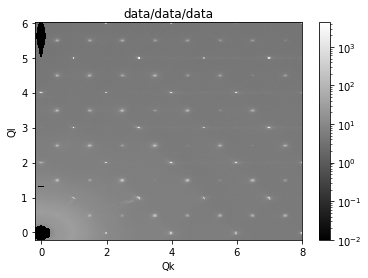

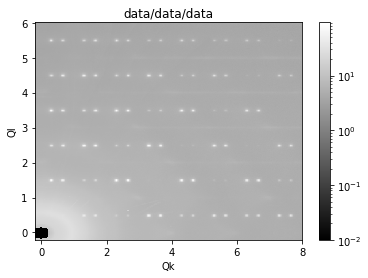

In [6]:
data.entry.symm_transform[-0.2:6.,-0.2:8.,0.0].data.plot(log=True,cmap=plt.cm.gray)
data.entry.symm_transform[-0.2:6.,-0.2:8.,1.0/6].data.plot(log=True, cmap=plt.cm.gray)

In [7]:
# Here we set a "large value" threshold
large_val = 2.65

# Here we set a curvature threshold
upper_curv_thresh = 0.15; lower_curv_thresh = -0.15

def getbraggs(x,dxx):
    return np.nonzero((x-np.rint(x))**2<(dxx/2)**2)[0]

## Look at the distribution of the log values in the dataset

In [8]:
z3d = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxvalue # - movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata
z3dl = np.log(z3d)
# Truncate the logarithm (simpler)
z3dl[z3dl < 0.0] = 0.0

# Take the laplacian of the data
elevation_mapz = laplace(-z3dl)

<ipython-input-8-b8b912eddbe0>:2: RuntimeWarning: divide by zero encountered in log
  z3dl = np.log(z3d)


<ipython-input-9-06bc36e5ee6a>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata[:,:,10]))


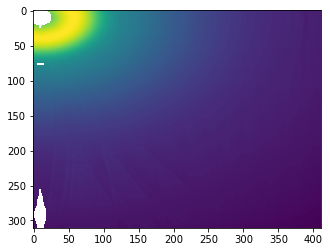

In [9]:
plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata[:,:,10]))

(-0.5, 410.5, -0.5, 310.5)

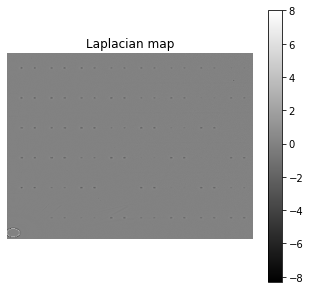

In [10]:
fig, ax = plt.subplots(figsize=(5.5, 5))
c = ax.imshow(elevation_mapz[:,:,20], cmap=plt.cm.gray, origin='lower')
fig.colorbar(c, ax=ax)
ax.set_title('Laplacian map')
ax.axis('off')

## Initialize X, Y, Z and dX, dY, and dZ

In [14]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Qh.nxvalue
dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]
# B_locs = getbraggs(x,dx)
# B_locs2 = getbraggs(x2,dx2)
# B_locs3 = getbraggs(x3,dx3)

# # Mark as background (0) all values by default, 
# # those with high curvature get the marker 1 and 
# # the Bragg locations get marked with 2
# markerz = np.zeros_like(z3dl)
# markerz[(elevation_mapz <= upper_curv_thresh)*(lower_curv_thresh <= elevation_mapz)] = 1
# markerz[z3dl > large_val] = 0
# for i in B_locs:
#     for j in B_locs2:
#         for k in B_locs3:
#             markerz[i,j,k] = 2
            
# dx,dx2,dx3

## Define the symmetrizing operation and the standard punch

In [15]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)
def flipaxis(A,i):
    Aprime=np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

def symmetrize(res):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background - not
    # rigorously based on anything
    # vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    # vvals[vvals < 0] = 0
    return vvals[0:600,0:800,0:800]

In [16]:
def standard_punch(x,x2,x3,z3d,rad):
    L,K,H = np.meshgrid(x,x2,x3,indexing='ij')
    print(L.shape)
    punch_locs = np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.5**2)+(H-np.rint(H))**2/(1.5**2))<(rad)**2,np.nan*np.ones(np.shape(z3d)),np.ones(np.shape(z3d)))
    # Perform the punch
    print(np.shape(punch_locs))
    punched   = np.multiply(z3d, punch_locs)
    nan_locs  = np.where(np.isnan(punched)==1,np.ones(np.shape(z3d)),np.zeros(np.shape(z3d)))
    return punched, nan_locs

In [17]:
#Note; change this path
julia.include("/Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/MaternKernelApproximation.jl")

<PyCall.jlwrap Laplace3D_Grid>

In [19]:
#Note: main - change matern to plaplace on line 26
# 1 - 8 has been used as the boundary - don't use an integer l.u.
#Matern Interpolation happens here.
epsilon = 0.
radius = 0.2001;
h = 0.02;
xmin = 1
xmax = 6
ymin = 1
ymax = 8
zmin = 1
zmax = 8
xbegin = ybegin = zbegin =-0.2
z3d_copy =np.copy(z3d)
z3d_restored = np.copy(z3d)
stride = 20;
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride
    i2 = i1+2*stride+1
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        #print(j1,j2)
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
            #print(k1,k2)
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2]
            # >>>>>>>>
            restored_img, punched_image = julia.Matern3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, epsilon, radius, h)
            # restored_img, punched_image = julia.Laplace3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, epsilon, radius, h)
            # <<<<<<
            # Everything is in z3d_restored
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken :", timeit.default_timer() - starttime)

Time taken : 149.5282602530001


In [20]:
#Laplace interpolation happens here.
#Interpolated data is in z3d_restored_laplace. Original in z3d.
xmin = 1
xmax = 6
ymin = 1
ymax = 8
zmin = 1
zmax = 8
xbegin = ybegin = zbegin =-0.2
z3d_copy =np.copy(z3d)
z3d_restored_laplace = np.copy(z3d)
stride = 20;
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride
    i2 = i1+2*stride+1
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        #print(j1,j2)
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
            #print(k1,k2)
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2]
            restored_img, punched_image = julia.Laplace3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, epsilon, radius, h)
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored_laplace[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken :", timeit.default_timer() - starttime)

Time taken : 43.471524313000145


Text(0.5, 1.0, 'Original data')

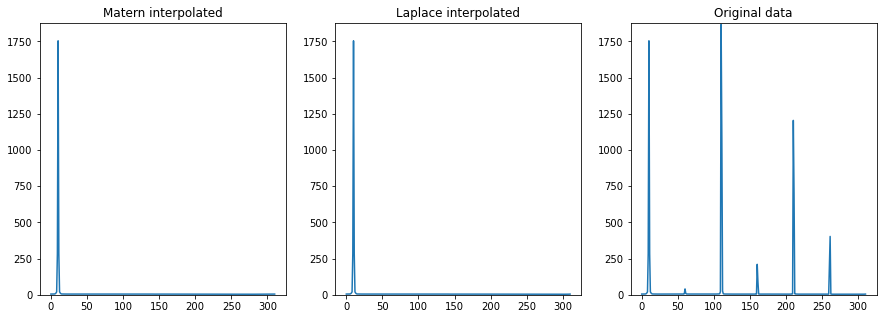

In [21]:
#plt.imshow(restored_img_reshaped[410,410,:].T)
#plt.imshow(z3d[:,:,410])
idx = 310;
idy = 210;
max1 = np.max(z3d_copy[:,idy,idx])
max2 = np.max(z3d[:,idy,idx])
max_y = np.max([max1, max2])+10
# fig,ax=plt.subplots(1,2, figsize=(10,5))
fig,ax=plt.subplots(1,3, figsize=(15,5))
ax[0].plot(z3d_restored[:, idy,idx])
ax[0].set_title("Matern interpolated")
ax[0].set_ylim([0, max_y])
ax[1].plot(z3d_restored_laplace[:, idy,idx])
ax[1].set_title("Laplace interpolated")
ax[1].set_ylim([0, max_y])
ax[2].plot(z3d[:,idy, idx])
ax[2].set_ylim([0, max_y])
ax[2].set_title("Original data")
# Note: log scale
# Note: do this for the Laplace one too

In [22]:
# Note: here is a quick error comparison
print(z3d[90:111,60,60] - z3d_restored[90:111,60,60])

[   0.          0.          0.       ...    1.435319    5.371087
 1186.1233  ]


In [23]:
punched, nan_locs = standard_punch(x,x2,x3,z3d,0.2001)

(311, 411, 411)
(311, 411, 411)


In [24]:
symmetrize(nan_locs).shape

(600, 800, 800)

## Save the watershed and standard punch locations to an .nxs file 

In [25]:
from pathlib import Path
home = str(Path.home())

# These are the axes
# Note: these paths need to be changed
expt_data = nxload(home+'/Research/BES_Project/Data/movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [26]:
# Save the standard punch locations -- Paths and names of the filenames need to be changed. So commenting
#out the Save command.
root = NXroot(NXentry())
# Make a nexus field for the Standard punch 
stdpunch = NXfield(symmetrize(nan_locs), name='standard_punch_locs')
root.entry.sphere_punch = NXdata(stdpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
# Note: these paths need to be changed
#root.save(home+'/Research/BES_Project/Data/punched/new_movo2_40_sphere_punch_locs.nxs')

# Interpolation step

In [29]:
def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i

    
class Gaussian3DKernel(Kernel):

    _separable = True
    _is_bool = False

    def __init__(self, stddev, **kwargs):
        x = np.linspace(-15., 15., 17)
        y = np.linspace(-15., 15., 17)
        z = np.linspace(-15., 15., 17)
        X,Y,Z = np.meshgrid(x,y,z)
        array = np.exp(-(X**2+Y**2+Z**2)/(2*stddev**2))
        self._default_size = _round_up_to_odd_integer(8 * stddev)
        super(Gaussian3DKernel, self).__init__(array)
        self.normalize()
        self._truncation = np.abs(1. - self._array.sum())

gkernal = Gaussian3DKernel(2)

def standard_fill(z3d, punched, nan_locs):
    vvals = convolve(punched,gkernal)
    res   = z3d*(1-nan_locs)+vvals*nan_locs
    return res

In [30]:
# Conventional punch and Gaussian fill
%time res = standard_fill(z3d,punched,nan_locs)

CPU times: user 10min 41s, sys: 2.11 s, total: 10min 43s
Wall time: 33min 18s


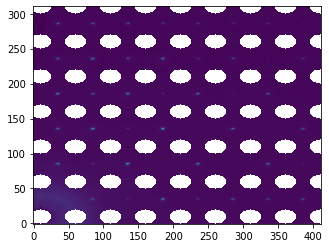

In [34]:
# plt.imshow(res[:,:,10], origin='lower')
plt.imshow(punched[:,:,10], origin='lower')

In [27]:
# Note: Save command is commented out. Change it as needed.
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored), name='sphere_punch_matern_interp_data')
root.entry.sphere_matern_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save('aux/movo2_40_sphere_matern_data.nxs')

In [38]:
# Note: Save command is commented out. Change it as needed.
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored_laplace), name='sphere_punch_laplace_interp_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save('aux/movo2_40_sphere_laplace_data.nxs')

NXroot('root')

In [39]:
# Note: Save command is commented out. Change it as needed.
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_copy), name='original_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save('aux/movo2_40_original_data.nxs')

NXroot('root')

In [ ]:
# Save the standard punch and fill result. Save command is commented out. Change it as needed.
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(res), name='sphere_punch_gauss_interp_data')
root.entry.sphere_gauss_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save('aux/movo2_40_sphere_gauss_data.nxs')

In [ ]:
# Save the sphere punch and Laplacian fill
root = NXroot(NXentry())
lapintroundpunch = NXfield(symmetrize(sphere_laplace), name='laplace_interp_sphere_punch')
root.entry.sphere_laplace_data = NXdata(lapintroundpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_sphere_laplace_data.nxs')

## In summary: times -- this needs to be changed.

|Algorithm | Time |
|:---|:---|
| Standard punch and fill | CPU times: user 4min 44s, sys: 880 ms, total: 4min 44s |
| | Wall time: 4min 43s |
| Watershed punch and standard fill| CPU times: user 4min 44s, sys: 1.16 s, total: 4min 45s |
| | Wall time: 4min 44s |
|laplacian w watershed punch | CPU times: user 22.2 s, sys: 15.4 s, total: 37.6 s
| | Wall time: 33.9 s |
|laplacian w standard punch | CPU times: user 43 s, sys: 14 s, total: 57 s |
| | Wall time: 46.9 s |
| Matern (m=2) w watershed punch | CPU times: user 53.8 s, sys: 1min 10s, total: 2min 4s |
| | Wall time: 2min 20s |
| Matern (m = 2) w standard punch | CPU times: user 3min 25s, sys: 1min 45s, total: 5min 10s |
| | Wall time: 3min 20s |

(Note that interpolation times are being reported here, time to compute the punch locations is not included.)
